## Analisi delle sintesi
Clustering gaussiano

In [2]:
import numpy as np
from sklearn.mixture import GaussianMixture

In [3]:
# carico i dati di una sintesi
synth_path = r'../data/out/synth/AnalMat2-1.pgm'
with open(synth_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.uint8)

data = data.reshape(-1, 36).astype(np.float32)
print(len(data))

2133550


In [4]:
# eseguo il Gaussian Mixture Model
n_clusters = 16
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', init_params='kmeans', max_iter=1000)

gmm.fit(data)

In [14]:
# qualità di clusterizzazione

print('BIC:', gmm.bic(data))
print('AIC:', gmm.aic(data))

BIC: -919708542.8638506
AIC: -919938345.028052


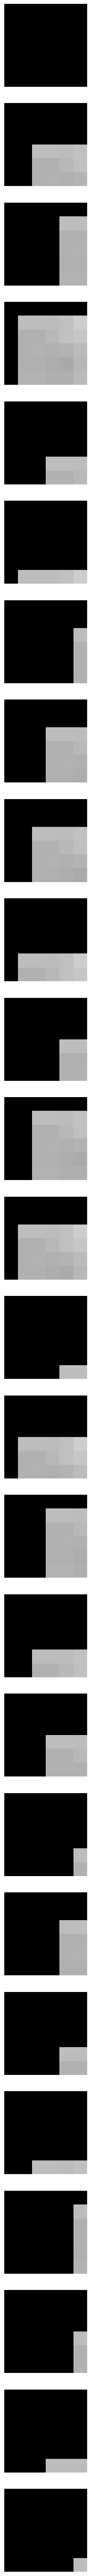

In [15]:
# plot dei centroidi individuati
import matplotlib.pyplot as plt

fig, ax = plt.subplots(n_clusters, 1, figsize=(3, 3 * n_clusters))
for i in range(n_clusters):
    ax[i].imshow(gmm.means_[i].reshape(6, 6), cmap='gray', vmin=0, vmax=255, interpolation='none')
    ax[i].axis('off')

In [21]:
# esaminiamo il cluster 0
print('Peso:', gmm.weights_[0])
print('Mean:', gmm.means_[0])
print('Covariance:', gmm.covariances_[0])

# mostro i valori labelati con il cluster 0
labels = gmm.predict(data)
cluster0 = data[labels == 0]
print(cluster0)

Peso: 0.9999882824400647
Mean: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Covariance: [[1.e-06 0.e+00 0.e+00 ... 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-06 0.e+00 ... 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-06 ... 0.e+00 0.e+00 0.e+00]
 ...
 [0.e+00 0.e+00 0.e+00 ... 1.e-06 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 ... 0.e+00 1.e-06 0.e+00]
 [0.e+00 0.e+00 0.e+00 ... 0.e+00 0.e+00 1.e-06]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Clustering

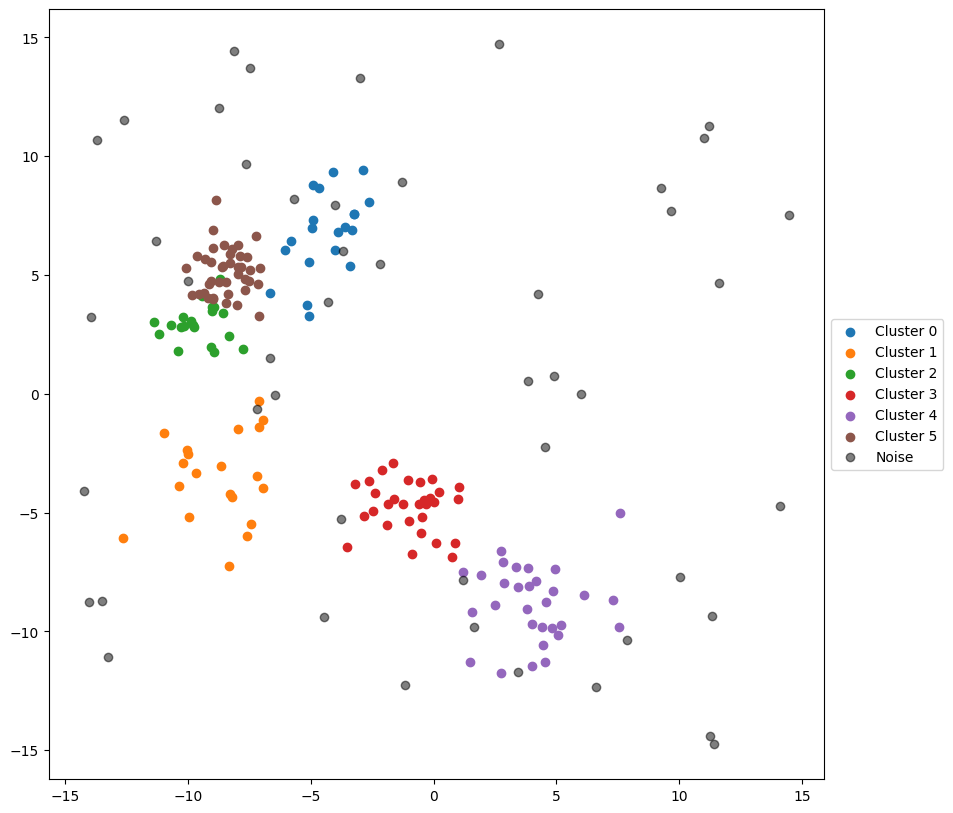

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# genero i dati:
N = 6
n_points = [20, 20, 20, 30, 30, 40]
noise_w = 0.3
# scelgo casualmente in [-10,10]x[-10,10] N centroidi a valori reali
centroids = np.random.rand(N, 2) * 20 - 10
# stabilisco delle varianze casuali per questi centroidi tra [0.5, 2]
variances = np.random.rand(N) * 1.5 + 0.5
# stabilisco il numero di punti per ogni cluster
# genero i punti
data = [np.random.randn(n, 2) * variances[i] + centroids[i] for i, n in enumerate(n_points)]

# inserisco del rumore: aggiungo dei punti uniformemente distribuiti in [-15,15]*[-15,15]
noise = np.random.rand(int(noise_w*sum(n_points)), 2) * 30 - 15

# plotto tutto
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(N):
    ax.scatter(data[i][:, 0], data[i][:, 1], label='Cluster %d' % i)

ax.scatter(noise[:, 0], noise[:, 1], label='Noise', c='black', alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


## KMeans algorithm

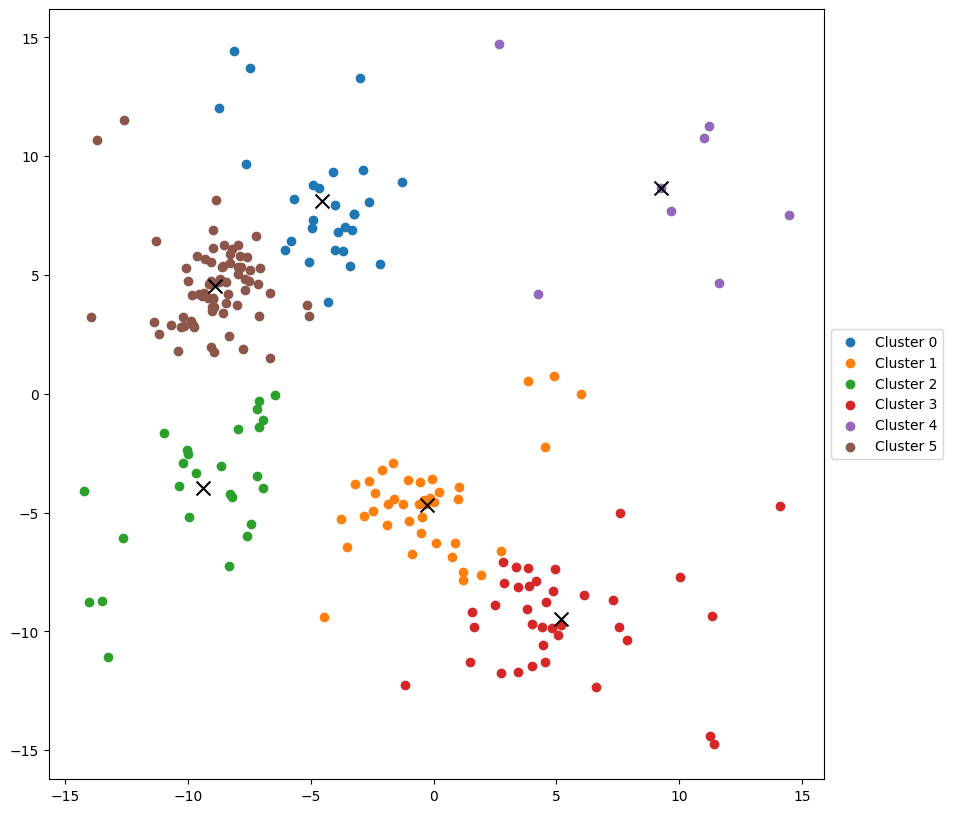

In [28]:
# eseguo il classico KMeans
from sklearn.cluster import KMeans

fused_data = np.concatenate(data + [noise])
kmeans = KMeans(n_clusters=N, init='k-means++', max_iter=1000)
kmeans.fit(fused_data)
labels = kmeans.predict(fused_data)

# plotto i risultati:
# i centroidi sono indicati con una x e i dati con dei cerchi
# il colore di un cluster è dettato dal label stimato con kmeans
plt.figure(figsize=(10, 10))
for i in range(N):
    plt.scatter(fused_data[labels == i][:, 0], fused_data[labels == i][:, 1], label='Cluster %d' % i)
    plt.scatter(kmeans.cluster_centers_[i][0], kmeans.cluster_centers_[i][1], marker='x', s=100, c='black')

# la legenda la voglio fuori dal plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Gaussian Mixture Clustering

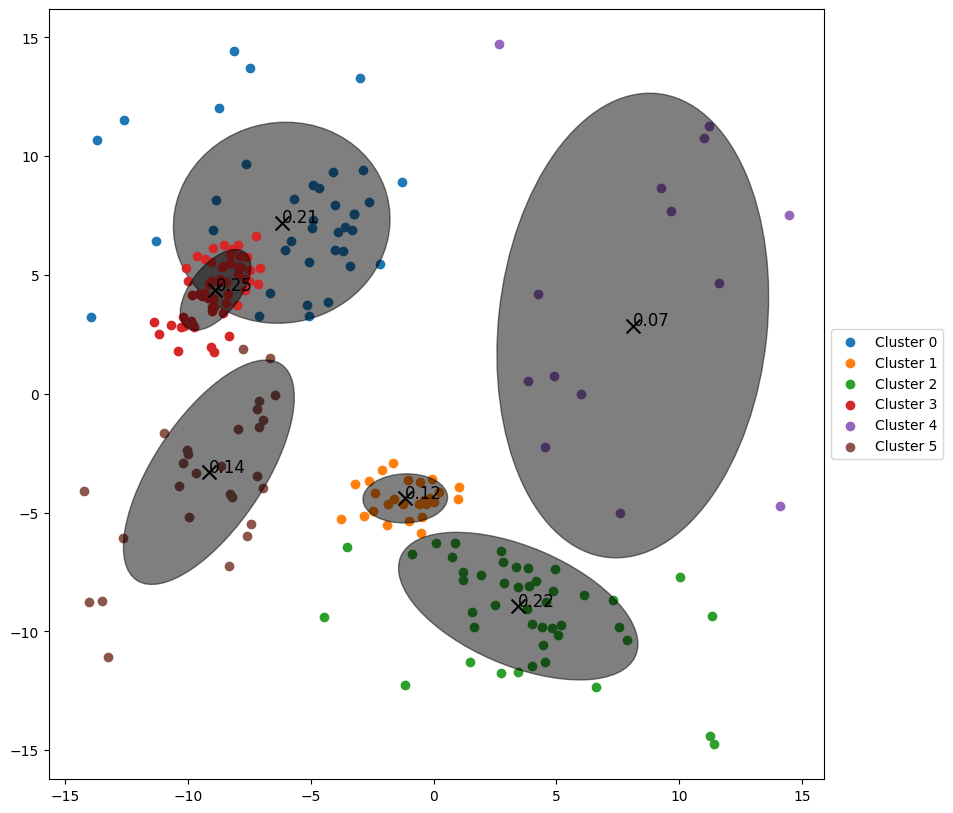

In [29]:
# eseguo il Gaussian Mixture Model
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

n_clusters = N
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', init_params='kmeans', max_iter=1000, tol=1e-6)

gmm.fit(fused_data)
labels = gmm.predict(fused_data)

# plotto i risultati:
# i centroidi sono indicati con una x e i dati con dei cerchi
# il colore di un cluster è dettato dal label stimato con gmm
# indico con un'ellisse la covarianza del cluster
# indico il peso del cluster con un numero vicino al centroide
plt.figure(figsize=(10, 10))
for i in range(N):
    plt.scatter(fused_data[labels == i][:, 0], fused_data[labels == i][:, 1], label='Cluster %d' % i)
    plt.scatter(gmm.means_[i][0], gmm.means_[i][1], marker='x', s=100, c='black')
    # inserisco l'ellisse
    cov = gmm.covariances_[i]
    v, w = np.linalg.eigh(cov)
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180 * angle / np.pi
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = Ellipse(xy=gmm.means_[i], width=v[0], height=v[1], angle=180 + angle, color='black', alpha=0.5)
    plt.gca().add_patch(ell)
    # peso del cluster
    plt.text(gmm.means_[i][0], gmm.means_[i][1], '%.2f' % gmm.weights_[i], fontsize=12)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## FCM algorithm

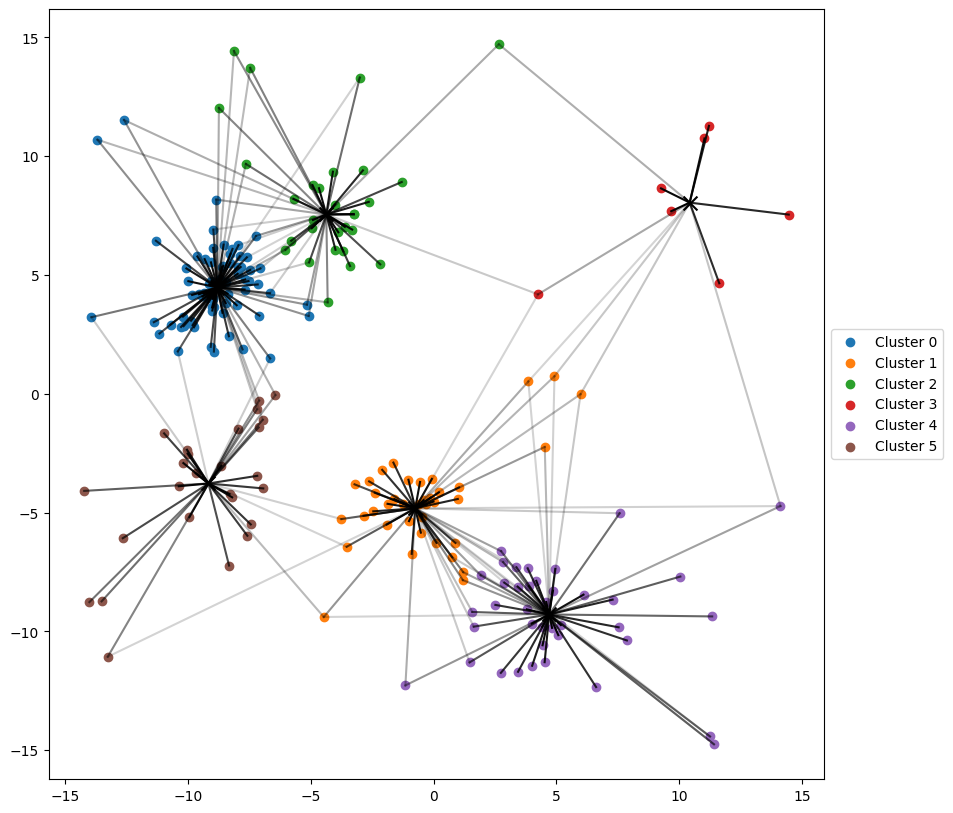

In [33]:
# eseguo la clusterizzazione FCM usando torch

# importo da matplotlib le linee
from matplotlib.lines import Line2D
import torch
# setto il device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# con kmeans stabilisco i centroidi iniziali
kmeans = KMeans(n_clusters=N, init='k-means++', max_iter=1000)
kmeans.fit(fused_data)
centroids = kmeans.cluster_centers_

# calcolo la matrice delle distanze a 2 a 2 tra dati e centroidi
data_torch = torch.tensor(fused_data, device=device)
centroids = torch.tensor(centroids, device=device)
m = 2

for i in range(10000):
    distances = torch.cdist(data_torch, centroids) ** (2/(m-1))
    # calcolo la matrice di membership
    U = 1 / (distances * torch.sum(1 / distances, dim=1, keepdim=True))

    # calcolo i nuovi centroidi
    Um = U ** m
    centroids = torch.matmul(Um.T, data_torch) / torch.sum(Um, dim=0, keepdim=True).T

# plotto i risultati:
# i centroidi sono indicati con una x e i dat9i con dei cerchi
# il colore di un cluster è dettato dal label stimato con fcm (argmax)
# il valore di tale collegamente è indicato con una linea tanto più chiara quanto più è basso
plt.figure(figsize=(10, 10))
labels = torch.argmax(U, dim=1)

# passo a numpy per poter usare le funzioni di matplotlib
labels = labels.cpu().numpy()
centroids = centroids.cpu().numpy()
U = U.cpu().numpy()
for i in range(N):
    plt.scatter(fused_data[labels==i][:,0], fused_data[labels==i][:,1], label='Cluster %d' % i)
    plt.scatter(centroids[i,0], centroids[i,1], marker='x', s=100, c='black')
for j in range(len(fused_data)):
    middle = 1./len(centroids)
    for i in range(N):
        if U[j,i] >= middle:
            line = Line2D(
                [fused_data[j,0], centroids[i,0]],
                [fused_data[j,1], centroids[i,1]],
                alpha=U[j,i],
                color='black',
            )
            plt.gca().add_line(line)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
    